In [232]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<font size=6>
    Sberbank Russian Housing Market
</font>

<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>
<font color='red' size=5>
    Summary: Feature Engineering with categorical data
    
</font>
<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>

1. The categorical columns are inspected.
    * 15 cols
    * `product_type` contains two non-ordinal labels
        * `'Investment', 'OwnerOccupier'`
    * `sub_area` contains 146 non-ordinal labels
        * regions in the city
    * `ecology` contiain 4 ordinal labels and 1 'no data'
        * 'no data' $\to$ `np.NaN` but _after_ encoding
            * `OrdinalEncoder` fails with NANs
    * the rest are "yes/no" labels
2. All columns are are converted to ordinal arrays
    * "yes/no"$\to$"1/0", 
    * `ecology = ['poor'...'excellent']` $\to$ `[0,...,3]` 
    * the rest are arbitrary

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../../datasets/sberbank-russian-housing-market/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../datasets/sberbank-russian-housing-market/sample_submission.csv
../../datasets/sberbank-russian-housing-market/macro.csv
../../datasets/sberbank-russian-housing-market/test.csv
../../datasets/sberbank-russian-housing-market/data_dictionary.txt
../../datasets/sberbank-russian-housing-market/train.csv
../../datasets/sberbank-russian-housing-market/sberbank-russian-housing-market.zip
../../datasets/sberbank-russian-housing-market/__MACOSX/._test.csv
../../datasets/sberbank-russian-housing-market/__MACOSX/._train.csv


## Load the data

In [3]:
df = pd.read_csv('../../datasets/sberbank-russian-housing-market/train.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [4]:
df.shape

(30471, 292)

In [17]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 292 columns):
id                                       30471 non-null int64
timestamp                                30471 non-null datetime64[ns]
full_sq                                  30471 non-null int64
life_sq                                  24088 non-null float64
floor                                    30304 non-null float64
max_floor                                20899 non-null float64
material                                 20899 non-null float64
build_year                               16866 non-null float64
num_room                                 20899 non-null float64
kitch_sq                                 20899 non-null float64
state                                    16912 non-null float64
product_type                             30471 non-null object
sub_area                                 30471 non-null object
area_m                                   30471 non-null f

#### Create a DF out of the `info()`

In [23]:
import io
buf = io.StringIO()
df.info(verbose=True, null_counts=True, buf=buf)
s = buf.getvalue()

In [49]:
nr_cols = df.shape[1]
info_list = s.split('\n')[3:nr_cols+3]
df_info = pd.DataFrame()
for v in info_list:
    v = v.split()
    dc = {}
    dc['col'] = [v[0]]
    dc['count'] = [int(v[1])]
    dc['type'] = [v[3]]
    #print(dc)
    df_row = pd.DataFrame().from_dict(dc)
    df_info = pd.concat([df_info, df_row])
df_info.reset_index(drop=True,inplace=True)

In [53]:
df_info.head()

,col,count,type
0,id,30471,int64
1,timestamp,30471,datetime64[ns]
2,full_sq,30471,int64
3,life_sq,24088,float64
4,floor,30304,float64


In [54]:
string_cols = df_info[df_info['type']=='object'].col.tolist()

In [210]:
df_string_cols = df[string_cols].copy()

In [211]:
df_string_cols.head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good
1,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent
2,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor
3,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good
4,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent


In [212]:
df_string_cols.describe()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
count,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471
unique,2,146,2,2,2,2,2,2,2,2,2,2,2,2,5
top,Investment,Poselenie Sosenskoe,no,no,no,no,no,no,no,no,no,no,no,no,poor
freq,19448,1776,28543,28817,28155,30175,19600,29335,27649,29608,27427,28134,29690,29578,8018


#### Encoding

In [213]:
yes_no_cols = [col for col in string_cols]# if (col != 'sub_area')]

In [214]:
df_string_cols['ecology'].head()

0         good
1    excellent
2         poor
3         good
4    excellent
Name: ecology, dtype: object

In [174]:
df_string_cols.sub_area.unique()

146

In [215]:
categ_list = [['Investment', 'OwnerOccupier']] + [df_string_cols.sub_area.unique().tolist()] + 12*[['no','yes']]+[['poor', 'satisfactory', 'good', 'excellent', 'no data']]

In [216]:
print(len(categ_list))
print(df_string_cols[yes_no_cols].shape)

15
(30471, 15)


In [217]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categ_list)

str_enc_data = enc.fit_transform(df_string_cols[yes_no_cols].values)

In [218]:
enc.categories_

[array(['Investment', 'OwnerOccupier'], dtype=object),
 array(['Bibirevo', 'Nagatinskij Zaton', "Tekstil'shhiki", 'Mitino',
        'Basmannoe', 'Nizhegorodskoe', "Sokol'niki", 'Koptevo', 'Kuncevo',
        'Kosino-Uhtomskoe', 'Zapadnoe Degunino', 'Presnenskoe',
        'Lefortovo', "Mar'ino", "Kuz'minki", 'Nagornoe', "Gol'janovo",
        'Vnukovo', 'Juzhnoe Tushino', 'Severnoe Tushino',
        "Chertanovo Central'noe", 'Fili Davydkovo', 'Otradnoe',
        'Novo-Peredelkino', 'Bogorodskoe', 'Jaroslavskoe', 'Strogino',
        'Hovrino', "Moskvorech'e-Saburovo", 'Staroe Krjukovo', 'Ljublino',
        'Caricyno', 'Veshnjaki', 'Danilovskoe', 'Preobrazhenskoe',
        "Kon'kovo", 'Brateevo', 'Vostochnoe Izmajlovo', 'Vyhino-Zhulebino',
        'Donskoe', 'Novogireevo', 'Juzhnoe Butovo', 'Sokol', 'Kurkino',
        'Izmajlovo', 'Severnoe Medvedkovo', 'Rostokino',
        'Orehovo-Borisovo Severnoe', 'Ochakovo-Matveevskoe', 'Taganskoe',
        'Dmitrovskoe', 'Orehovo-Borisovo Juzhnoe', '

In [219]:
df_string_cols[yes_no_cols] = str_enc_data
#df_string_cols = str_enc_data

In [220]:
#df_string_cols[df_string_cols['ecology']=='no data'].loc[:,'no data'] = np.NaN
encoder_max = df_string_cols.ecology.max()
df_string_cols['ecology'] = np.where(df_string_cols.ecology==df_string_cols.ecology.max(), np.NaN, df_string_cols.ecology)

In [221]:
df_string_cols[df_string_cols['ecology']=='no data'].head()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology


In [222]:
df_string_cols[df_string_cols['ecology']==encoder_max].head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology


In [223]:
df_string_cols[df_string_cols['ecology'].isna()].head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
20,0,17,0,0,0,0,0,0,0,0,0,0,0,0,NaN
34,0,29,0,0,0,0,0,0,0,0,0,0,0,0,NaN
87,0,29,0,0,0,0,0,0,0,0,0,0,0,0,NaN
112,0,65,0,0,0,0,0,0,0,0,0,0,0,0,NaN
122,0,69,0,0,0,0,0,0,0,0,0,0,0,0,NaN


In [224]:
df_string_cols.head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,3.0
2,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0.0
3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,2.0
4,0,4,0,0,0,0,1,1,0,0,0,0,0,1,3.0


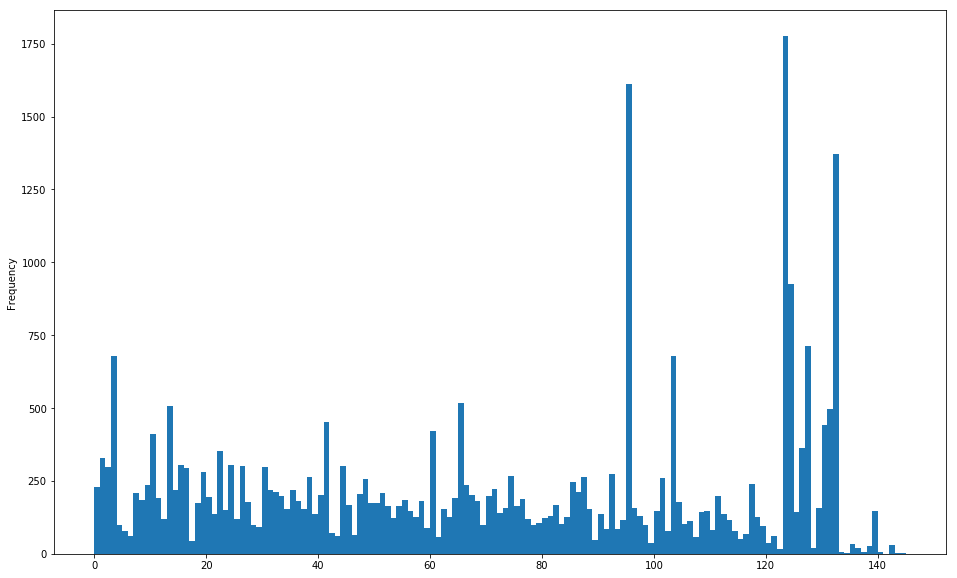

In [235]:
ax = df_string_cols.sub_area.plot.hist(bins=range(146), figsize=[16,10])
